# Introduction

The report is based on getting two different type of similarity algorithms. Few questions and analysis are about Jaccard’s similarity and the cosine similarity and their running time. Hence, the report is mostly evolved around finding algorithms for Jaccard' similarity and cosine similarity and running time respectively and estimation of various constants.

In question 1, I start the report with an estimate and analyse of the theoretical running time of Jaccard's similarity measure applied to documents represented as bags of words. Question 2, I examining the theoretical worst-case running time of the cosine similarity to documents, which are represented as dense vectors. Later on, I compare using the implementation of the dot product in numpy with my own implementation. 

In question 3, after comparison between two similarities, I estimate and analyse that cosine similarity directly computes documents from sparse(dictionary) representations without converting them into dense(vector) representations. Also, I compare the previous implementation of the two similarities. Question 4, I estimate all-pairs similarities for a collection of documents. Moreover, I also estimate, the theoretical worst-case running time for computing all-pairs similarities and provide an estimation of how long it would take to compute all-pairs similarities for 200K documents for both measures. 

At last, for question 5, I use the map-reduce computing method to implement a parallel version of all-pairs similarities for documents.

In [1]:
#import the required module
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from timeit import default_timer as timer
import nltk
from nltk.corpus import semcor
from nltk.corpus import inaugural
from nltk.corpus import stopwords
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import time
import operator
from multiprocessing import Pool
from collections import defaultdict

Let's download various nltk corpus packages.

In [2]:
nltk.download('brown')
nltk.download('semcor')
nltk.download('inaugural')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

collecting 40 documents.

In [3]:
#list of file_ids
files=brown.fileids() 
len(files)
sec_doc=[]
for temp in range(40):
    sec_doc.append(brown.words(files[temp]))

After collecting documents, we need to find the mean or average running time.

In [4]:
def timeit(somefunc,*args,repeats=10,**kwargs):
    times=[]
    while repeats>0:
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
        repeats-=1
    
    mean=np.mean(times)
 
    return mean
#I used the timeit function, to find the average time

Lets have few pre processing natural language text methods : tokenisation, normalistion, filtering stopwords and creating bag of words.

In [5]:
def token_frequency(tokens):
    freqs = {}
    for token in tokens:
        try :
            freqs[token] += 1
        except KeyError:
            freqs[token] = 1
    return freqs

In [6]:
def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

def filter_stopwords(tokenlist):
    stop = stopwords.words('english')
    return [w for w in tokenlist if w.isalpha() and w not in stop]

def create_bow(somestring):
    rep=normalise(somestring)   
    rep=filter_stopwords(rep)  
    dict_rep={}
    for token in rep:
        dict_rep[token]=dict_rep.get(token,0)+1  
    return(dict_rep)

In [7]:
my_file=[]
for doc_m in sec_doc:
    my_file.append(create_bow(doc_m))

In [8]:
def create_chart(num_mx,time_my,names):
    logxs=[np.log10(x) for x in num_mx]
    logys=[np.log10(y) for y in time_my]
    
    plt.subplots_adjust(1,0,2.5,0.5)
    plt.subplot(121)
    plt.plot(num_mx,time_my)
    plt.xlabel("Length of List")
    plt.ylabel("Average time")
    plt.title("Worst Case Running Time of "+ names)
    #plt.ylim(-6,-3)
    
    plt.subplot(122)
    plt.scatter(logxs,logys)
    plt.xlabel("Length of List")
    plt.ylabel("Average time")
    plt.title("Worst Case Running Time of "+ names)
    plt.show()
    
    return logxs,logys
def cal_slope(logxs, logys):
    slope, intercept, r_value, p_value, std_err = stats.linregress(logxs, logys)
    print("Slope is {} and intercept is {}".format(slope,intercept))
    

1. Present an analysis of the theoretical running time of Jaccard’s similarity measure applied to large documents represented as bags of words (in a Python dictionary). Test your analysis empirically by timing and plotting various calculations of Jaccard similarity on your computer. Estimate relevant constants for your implementation and computer.

In [9]:
def jacd_sim(A, B):
    U = A.keys() | B.keys()
    I = A.keys() & B.keys()
    jacd =  len(I) / len(U)
    return jacd    

### An analysis of the theoretical running time of jaccard's similarity:

Jaccard's similarity is used to find the similarity and diversity of sample sets. We measure the similarity by jaccard coefficient and it is always measure the similarity between the finite sets. Jaccard coefficient is the ratio of size of intersection over the union of the two sets.

* If the both sets have the same elements then both are considered as similar to each other and their similarity is 1.
* If both sets have distincts elements then both are dissimilar to each other and similarity is 0.
* For jaccard similarity, we need to find the the following units:
    * Union of two sets : $O(len(doc1.items)+len(doc2.items))$.
    * Intersection of the two sets: $O(len(doc1.items)*len(doc2.items))$.
    * division of intersection over union.
* Jaccard similarity running time depend upon the document size. If the document is of size n, the jaccard similarity running time is O(n).

 

In [10]:
timexs=[]
sima_x=[]
doc_num=[]
cal_ti=0
for i in range(20):
    timess = []
    for ca_num in range(10):
        start = timer()
        sim_A_B = jacd_sim(my_file[0],my_file[i])
        end = timer()
        cal_ti+=(end - start)
    timek=(cal_ti/10)
    sima_x.append(str(round(sim_A_B,4)))
    timexs.append(round(end - start,7))
    doc_num.append(len(my_file[0])+len(my_file[i]))
    tem_s=round((len(my_file[0]) - len(my_file[i])*sim_A_B))
    print(round(timek,7),round(sim_A_B,4),len(my_file[0])+len(my_file[i]),tem_s)

9.13e-05 1.0 1286 0
0.0002074 0.1447 1337 543
0.0003133 0.1273 1231 568
0.0004596 0.1028 1363 569
0.0005811 0.1475 1229 557
0.0006879 0.1278 1280 562
0.0008 0.1291 1312 557
0.0009074 0.1304 1266 562
0.0010148 0.1131 1299 569
0.0011257 0.1357 1322 551
0.0012322 0.0774 1322 590
0.0013324 0.0912 1221 590
0.0014398 0.0743 1302 594
0.0015874 0.0956 1352 575
0.0016902 0.0916 1275 585
0.0018314 0.0826 1429 578
0.0019676 0.0853 1362 582
0.0021111 0.0739 1323 593
0.0022255 0.1145 1314 566
0.0023469 0.1063 1343 569


In [11]:
store_doc=[]
store_doc.append(timexs)

store_doc.append(sima_x)

store_doc.append(doc_num)

df=pd.DataFrame(store_doc, index=['Running time','similarity','number of words'])
df=df.T
df.sort_values('similarity')

,Running time,similarity,number of words
17,0.0001606,0.0739,1323
12,9.16e-05,0.0743,1302
10,9.15e-05,0.0774,1322
15,0.0001263,0.0826,1429
16,0.0001241,0.0853,1362
11,8.61e-05,0.0912,1221
14,8.74e-05,0.0916,1275
13,0.0001246,0.0956,1352
3,0.0001249,0.1028,1363
19,9.88e-05,0.1063,1343


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

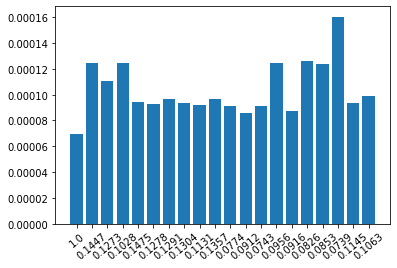

In [12]:
plt.bar(sima_x,timexs)
plt.xticks(rotation=40)

The above bar chart shows relationship between the jaccard's similarity and the running time. From the chart, it is clearly visible that the running time does not depend upon the similarity. 

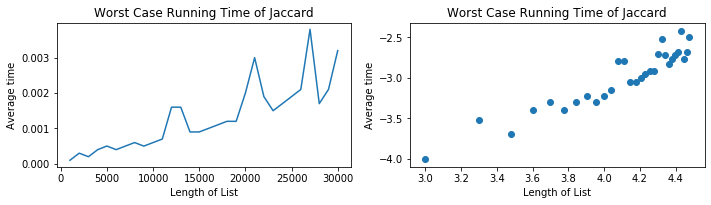

Slope is 0.9412580503629963 and intercept is -6.851061455499183


In [ ]:
times = []
number=[]
for n in range(1000, 300 * 100 + 1, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])
    
#     start = timer()
#     sim_A_B = jacd_sim(A,B)
#     end = timer()
    
    run_time=timeit(jacd_sim,A,B)
#     print(n)
    number.append(n)
    times.append(run_time)

lx,ly=create_chart(number,times,'Jaccard')
cal_slope(lx,ly)

I have estimated the constant for both my implementation and computer. Moreover, I have investigated the running time of this algorithm for different lengths of documents. 

The first chart above depicts that when number of documents increases from 1000 to 30000 then there is a significant rise in the average time. 

If the running time of jaccard's similarity is linear then we represent it by $O(n^1)$. For more calculation, let we have a function **y=ca*x^n** for further investigation, I take log both the side : **log(y)=log(ca)+nlog(x)**. Now, if I plot a graph between both the variables, the gradient is **n** and the intercept is **log(ca)**.

From the second chart, I got the gradient and intercept around 0.94 and -6.85.Moreover,here the gradient is quite close to 1 (can consider as a straight line). Moreover, empirically the running time is **O(n^ 0.94)**, which is better than **O(n)**. Ultimately, if the number of words increases the running time is going to be close to **O(n)**.

2.What is the theoretical worst case running time of the cosine similarity measure applied to documents represented as (dense representation) vectors? Show that this is the case empirically. Estimate the constant for your implementation and computer. Compare using the implementation of the dot product in numpy with your own implementation.

### Cosine similarity:

Cosine similarity is a method to measure how similar the documents are. It calculate the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity. If the angle between them are zero, it means they both are similar to each other. If they both are at perpendicular, the angle is zero and both are dissimilar to each other. 

**Cosine similarity formula:**

$cos\theta = \cfrac{A\cdot B}{\sqrt{A\cdot A}\sqrt{B\cdot B}}$

### The theoretical worst-case running time analysis of cosine similarity:



Cosine similarity usually measure a real-valued vector. The vector represents objects.Before,to measure the similarity of cosine,I need to find documents, which are represented as dense vectors. In ADS lab, I used the function **make_matrix** to make the matrix from a dictionary of frequency. So I used it over too. Hence to calulate the dense vectors for cosine similarity, there are few setps to follow. Initially, I used **for loop** to iterate it thorugh the arrays. The worst running time of cosine similarity is **O(n)**. 

In [39]:
# The function is to make the dense vectors from the dictionary representation of documents 
def make_matrix(list_of_dicts):
    #lets make a list of all of the features that comes in any document - these will be the dimensions of the matrix
    allfeatures={}    
    for docdict in list_of_dicts:
        for feat in docdict.keys():
            allfeatures[feat]=1
    dimensions=list(allfeatures.keys())
    #don't strictly need to sort it - but it is good practise to make sure it is reproducible
    sort_dim=sorted(dimensions)
    matrix=[]
    #each row in the matrix will be one of the dimensions
    for dimension in dimensions:
        row=[]
        #look up the appropriate value for each document
        for docdict in list_of_dicts:
            row.append(docdict.get(dimension,0)) #this will append the document's value if present, 0 otherwise
        matrix.append(row)
        
        
    return matrix

##lets transpose a matrix so we can compare documents
def transpose(matrix):
    transposed=[]
    for i in range(0,len(matrix[0])):
        transposed.append([row[i] for row in matrix])
        
    return transposed
#call make_matrix on whatever variable holds your list of dictionaries representation of your documents

In [40]:
#lets measure cosine similarity
def L2_norm(A):
    sq_sum = 0
    for i in range(len(A)):
        sq_sum += A[i]**2
    return sq_sum**0.5


def cosine_sim(A, B):
    
    dot_prod = 0
    for i in range(len(A)):
        dot_prod += A[i] * B[i]

    L2_A = L2_norm(A)
    L2_B = L2_norm(B)
    
    return dot_prod / (L2_A * L2_B)

At last, results of dot product divided by results of magnitude provide us the value of the cosine similarity constant. From above analyses, I considered that running time of the measure is about **O(n)** . Later, It will measure the constant for my implementation and computer as well. In addition to, it would be compared using the implementation of the dot product in numpy with my own implementation.

Cosine similarity measure with **vector** iteration states that we apply for loop documents iteration to compute documents represented as dense vectors (dense representation).

In [41]:
tim_1 = []

for n in range(1000, 300 * 100 + 1, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])
    
    MT = np.array(transpose(make_matrix([A,B])))
    
    run_time=timeit(cosine_sim,MT[0], MT[1])
    tim_1.append(run_time)


The worst-case running time for cosine similarly measure investigate for different lengths of documents words between 1000 and 30000 with a variation of 1000.

In [ ]:
#dot product with dense vectors
def cosine_sim_dot(A, B):
    
    dot_prod = 0
    
    dot_prod =np.dot(A,B)

    L2_A = L2_norm(A)
    L2_B = L2_norm(B)
    
    return dot_prod / (L2_A * L2_B)

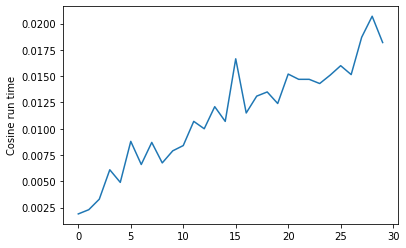

In [ ]:
tim_2 = []

for n in range(1000, 300 * 100 + 1, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])

    MT = np.array(transpose(make_matrix([A,B])))
    
    run_time=timeit(cosine_sim_dot,MT[0], MT[1])
    tim_2.append(run_time)

    
plt.plot(tim_2)
plt.ylabel('Cosine run time')
plt.show()

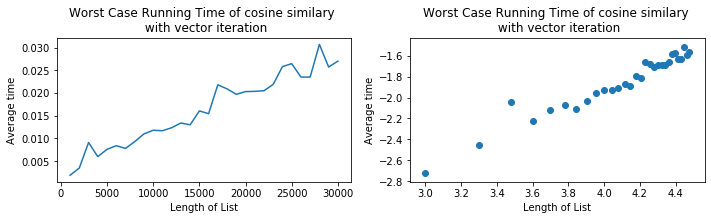

Slope is 0.7349761822553892 and intercept is -4.857217034638116


In [ ]:
#consine of documents iteration
lx,ly=create_chart(number,tim_1,'cosine similary \n with vector iteration')
cal_slope(lx,ly)

The above graphs show the cosine similarity with vector iteration

Cosine similarity measure with **numpy dot** product that it applies the numpy dot product.

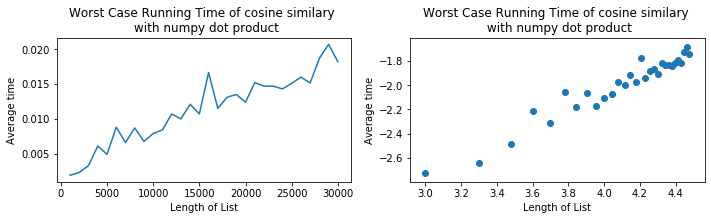

Slope is 0.6814754380604235 and intercept is -4.786348308223207


In [ ]:
#consine similarity with numpy dot product
lx,ly=create_chart(number,tim_2,'cosine similary \n with numpy dot product')
cal_slope(lx,ly)

From the above charts of cosine similarity measure with vector iteration and numpy dot product, I have noticed few things, which are given below:

* Initially, when I started increasing the documents length from 1000 to 30000,the running time has also increased conversely.
* The cosine similarity with vector and cosine similarity with numpy dot product has the same variation. It has found that the worst running time trend similar, which is linear **$𝑂(𝑛^1)$**.
* Also, the gradient of cosine similarity with vector iteration and cosine similarity measure with numpy dot product were around 0.73 and 0.68 respectively.
* Their intercept were approximately -4.85 and -4.78 respectively.
* From the above analyis, I can say that the worst running times of their cosine similarity are $y=10^{-5}*x^{0.73}$ and $y=10^{-5}*x^{0.68}$.

Now let’s do comparison between the two dot product with **vector iteration** and **numpy dot product**.

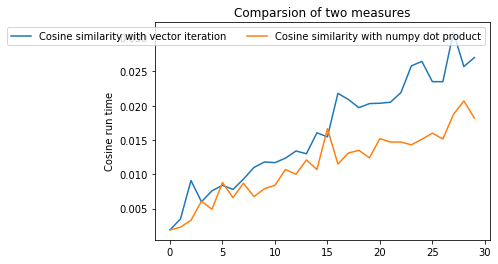

In [ ]:
plt.plot(tim_1)
plt.plot(tim_2)
plt.title("Comparsion of two measures")

label = ["Cosine similarity with vector iteration","Cosine similarity with numpy dot product"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel('Cosine run time')
plt.show()

Finally, from the above comparison, the two curves have a similar trend. But if we use the numpy dot, the running time would be reduced. Therefore, if we apply cosine similarity with numpy dot product, it would more effective.

3.Write a function which computes cosine similarity directly from sparse (dictionary) representations without converting them into dense (vector) representations. Test your function for correctness and compare its efficiency theoretically and empirically to (i) your previous implementation of the cosine similarity, and (ii) your implementation of Jaccard’s measure.

In [ ]:
A = token_frequency(brown.words()[0:100])
B= token_frequency(brown.words()[100:200])
print(A,'\n',B)

{'The': 3, 'Fulton': 2, 'County': 1, 'Grand': 1, 'Jury': 1, 'said': 2, 'Friday': 1, 'an': 1, 'investigation': 1, 'of': 5, "Atlanta's": 1, 'recent': 1, 'primary': 2, 'election': 3, 'produced': 1, '``': 3, 'no': 1, 'evidence': 1, "''": 3, 'that': 2, 'any': 1, 'irregularities': 2, 'took': 1, 'place': 1, '.': 2, 'jury': 2, 'further': 1, 'in': 3, 'term-end': 1, 'presentments': 1, 'the': 7, 'City': 2, 'Executive': 1, 'Committee': 1, ',': 2, 'which': 3, 'had': 2, 'over-all': 1, 'charge': 1, 'deserves': 1, 'praise': 1, 'and': 1, 'thanks': 1, 'Atlanta': 1, 'for': 1, 'manner': 1, 'was': 2, 'conducted': 1, 'September-October': 1, 'term': 1, 'been': 1, 'charged': 1, 'by': 2, 'Superior': 1, 'Court': 1, 'Judge': 1, 'Durwood': 1, 'Pye': 1, 'to': 1, 'investigate': 1, 'reports': 1, 'possible': 1, 'hard-fought': 1, 'won': 1, 'Mayor-nominate': 1, 'Ivan': 1} 
 {'Allen': 1, 'Jr.': 1, '.': 4, '``': 4, 'Only': 1, 'a': 2, 'relative': 1, 'handful': 1, 'of': 6, 'such': 1, 'reports': 1, 'was': 1, 'received': 1, 

In [ ]:
from math import sqrt
def dot(d1,d2):
    if len(d1) < len(d2):
        a = d1
        b = d2
    else:
        a = d2
        b = d1
    dotproduct = 0
    for word,count in a.items():
        dotproduct += count * b.get(word,0)
    return dotproduct

def cos_sim_dir(d1,d2):
    numerator = dot(d1,d2)
    denominator = sqrt(dot(d1,d1)*dot(d2,d2))
    return numerator/denominator

I write a function which measures the cosine similarity directly from sparse (dictionary) representations without converting them into dense (vector) representations. It means that it compute cosine similarity by keys and frequency of dictionary. 

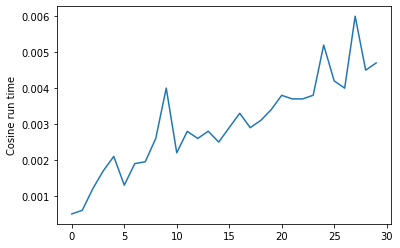

In [ ]:
def cos_dense_dir():
#     times_cose1 = []
    times_cos2 = []
    numberxs=[]
    for n in range(1000, 300 * 100 + 1, 1000):
    
        A = token_frequency(brown.words()[:n])
        B = token_frequency(brown.words()[n:2*n])
    
        numberxs.append(n)
        
        run_time=timeit(cos_sim_dir,A, B)
        times_cos2.append(run_time)
   

    plt.plot(times_cos2)
    plt.ylabel('Cosine run time')
    plt.show()
        
    return times_cos2,numberxs
cos_den=cos_dense_dir()

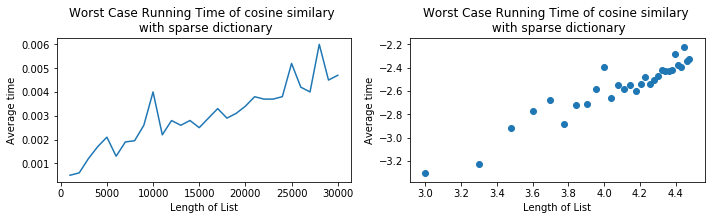

Slope is 0.6394915728463746 and intercept is -5.187418641738503


In [ ]:
lcx,lcy=create_chart(cos_den[1],cos_den[0],'cosine similary \n with sparse dictionary')
cal_slope(lcx,lcy)

* The two charts above show the worst-case running time of cosine similarity measure as dictionary representation, the first chart depicts that the running time is increasing with increasing in the number of words. 
* The second chart of worst-case running time of cosine similarity measure as dictionary.
* Its gradient is around 0.63. Its intercept is about -5.18.

**Comparison among the different similarity measures**.

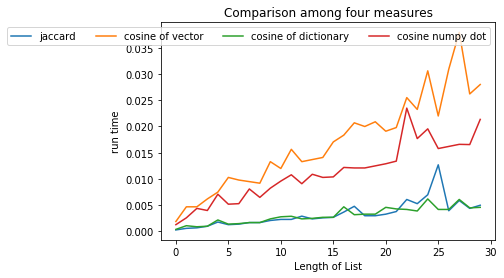

In [ ]:
def cos_dense_dir():
    times_cos1 = []
    times_cos2 = []
    times_jac=[]
    times_cos_dot=[]
    for n in range(1000, 300 * 100 + 1, 1000):
    
        A = token_frequency(brown.words()[:n])
        B = token_frequency(brown.words()[n:2*n])
    
    
        MT = np.array(transpose(make_matrix([A,B])))
        
       
        #cosine's similarly of vectors
        
        running_time1=timeit(cosine_sim,MT[0], MT[1])
        times_cos1.append(running_time1)
        

        #cosine's similarly of dictionary
        
        running_time2=timeit(cos_sim_dir,A, B)
        times_cos2.append(running_time2)
        
         # jaccard's similarly

        
        running_time3=timeit(cos_sim_dir,A, B)
        times_jac.append(running_time3)
        
        #cosine's similarly of numpy dot
        running_time4=timeit(cosine_sim_dot,MT[0], MT[1])
        times_cos_dot.append(running_time4)
        
    plt.plot(times_jac)   
    plt.plot(times_cos1)
    plt.plot(times_cos2)
    plt.plot(times_cos_dot)
    
    plt.xlabel("Length of List")
    plt.title("Comparison among four measures")
    label = ["jaccard", "cosine of vector","cosine of dictionary","cosine numpy dot"]
    plt.legend(label, loc = 0, ncol = 4)
    plt.ylabel('run time')
    plt.show()
        
    return times_cos2
cos_den=cos_dense_dir()

* From the above graph, it is clearly visible that all the four algorithms have similar trend.
* The cosine curve for vector has been higher than rest.
* Jaccard and cosine for dictionary has similar trend.
* All the four measure depends upon their length of document, if the length gets increase then the running time get increase as well.

4.Write a function which computes all-pairs similarities for a collection of documents. The function should take a list of dictionaries (the document collection) and a parameter specifying the similarity measure to be used. What is the theoretical worst-case running time for computing all-pairs similarities? Does it matter what the similarity measure is? Can you give an estimate of how long it would take to compute all-pairs similarities for 200K documents for both measures? (Note: that whilst you should test your function for all-pairs similarities (with d > 10), you do not need to prove the theoretical worst case empirically or test with 200K documents!)

In [ ]:
def all_pair_sim(func,value):
    sims= []
    time_collection=[]
    number_collection=[]
    k_num=0
    j_num=0

    most_similar = (0,0,0)
    
    if value==1:
        for i in range(len(my_file)-1):
            for j in range(i+1, len(my_file)):
                start = timer()
                sim_i_j = func(my_file[i], my_file[j])
                end = timer()
                k_num=k_num+(end-start)
                time_collection.append(k_num)
                j_num+=1
                number_collection.append(j_num)
    else: 
        for numk in range(48):
            my_docs=my_file[0:numk+1]
            start = timer()
            k_num=0
            for i in range(len(my_docs)-1):
                for j in range(i+1, len(my_docs)):
                    sim_i_j = func(my_file[i], my_file[j])
            end = timer()
            k_num=(end-start)
            time_collection.append(k_num)
            number_collection.append(len(my_docs))       
            

    return number_collection,time_collection

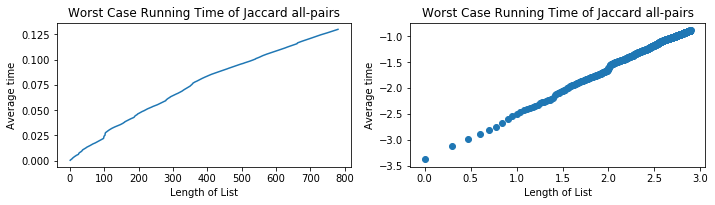

Slope is 0.8557734974760681 and intercept is -3.3265185799608377


In [ ]:
#only compuating Jaccard's similary 
xj,yj=all_pair_sim(jacd_sim,1)
lx,ly=create_chart(xj,yj,'Jaccard all-pairs')
cal_slope(lx,ly)

The above charts show the result without iteration. The worst running time of Jaccard' similarity measure also is similar O(n). Here the slope and intercept are 0.855 and -3.32 respectively. The y intercept is about $−3$ 𝑠𝑜 $𝑐𝑎≈10^{−3}=0.001$. Hence the worst running time $𝑦=𝑐𝑎.𝑥^{0.855}$ . we have $𝑂(𝑛^{0.855})$. We have $y=10^{-3}x^{0.855}$, let's we have 200k documents then,it is **$y=10^{-3}(200000)^{0.855} \approx. 200 $**


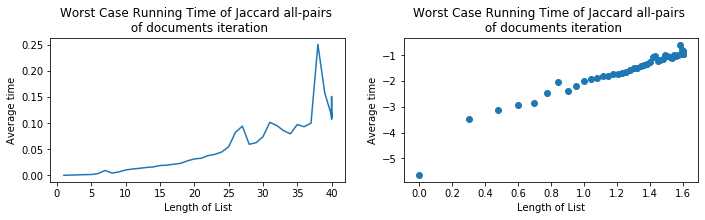

Slope is 2.288630433929005 and intercept is -4.4751441201513975


In [ ]:
xj,yj=all_pair_sim(jacd_sim,0)
lx,ly=create_chart(xj,yj,'Jaccard all-pairs \n of documents iteration')
cal_slope(lx,ly)

The above charts, we iterated it for documents and got the slope and intercept are 2.28 and -4.47 respectively. This illustrates that empirically we have $𝑂(𝑛^{2.28})$. Its worst running time is that $10^{-4}*x^{2} $.

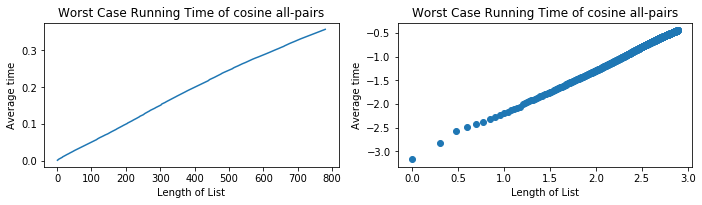

Slope is 0.9443260415265506 and intercept is -3.1666741494615454


In [ ]:
xc,yc=all_pair_sim(cos_sim_dir,1)
lx,ly=create_chart(xc,yc,'cosine all-pairs')
cal_slope(lx,ly)

The above charts shows trend without iterations. The slope and intercept are 0.94 and -3.166. The y intercept is about $−3$ 𝑠𝑜 $𝑐𝑎≈10^{−3}\approx 0.001$. I estimate the worst running time $𝑦=𝑐𝑎.𝑥^𝑛⟶𝑂(𝑛^{0.94})$. This hints that empirically we have $𝑂(𝑛^{0.94})$. If the number of documents are 200k, I have an estimate that $y=10^{-3}*200000 \approx 200 $.

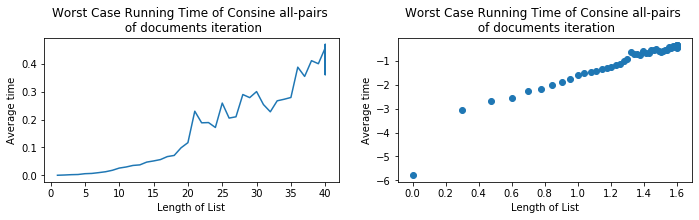

Slope is 2.5159861084884447 and intercept is -4.280233202974514


In [ ]:
xc,yc=all_pair_sim(cos_sim_dir,0)
lx,ly=create_chart(xc,yc,'Consine all-pairs \n of documents iteration')
cal_slope(lx,ly)

When there is an iteration in documents, its slope and intercept were 2.51 and -4.280. Therefore, it have $O(n^{2.51})$ and $Ca \approx. -4.280$. So y is $10^{-4.280}*(200000)^{2.51}$. Additionally, if the documents get increases, its worst running time is estimated about $10^{-4.280}*(200000)^{3}$.

5.Write a function that implements all-pairs similarities for documents and uses some form of parallel computing, e.g. MapReduce. Make sure you test your function empirically for correctness and for efficiency. Investigate the number of parallel processes that gives optimal results for your implementation and computer.

In [19]:
def allpair_simi(doc_dict):
    my_sims= []
    for i in range(len(my_file)-1):
        my_sims.append([])
        for j in range(i+1, len(my_file)):
            my_sims[i].append([i,j])
    return my_sims

In [20]:
# my mapper function
def mapper_parallel(doc):
     output=[]
    
     for num in doc:
        output.append((str(num[0]),num))
        
#         print(num)
#         print(str(document[0][0]))

     return output

In [21]:
#my Jaccard'similarity reducer function
def reducer_jac(value):
    output=[]
    (word,counts)=value
    for couns in counts:
#       print(word,couns)
      
      A=my_file[couns[0]]
      B=my_file[couns[1]]
      U = A.keys() | B.keys()
      I = A.keys() & B.keys()
      jac =  len(I) / len(U)
      
      output.append(((couns[0],couns[1]),jac))
    return output

In [22]:
#my cosine similarity reducer  function
def reducer_cos(value):
    output=[]
    (word,counts)=value
    for couns in counts:
#       print(word,couns)
      
      A=my_file[couns[0]]
      B=my_file[couns[1]]
      numerator = dot(A,B)
      denominator = sqrt(dot(A,A)*dot(B,B))
      cosine_sim=numerator/denominator
      
      output.append(((couns[0],couns[1]),cosine_sim))
    return output

In [29]:
def map_reduce_parallel(docm,allpair_mapper,allpair_reducer,mapprocesses=3,reduceprocesses=2):
  outputs=[]
  collector=defaultdict(list)  #this dictionary is where we will store intermediate results
                                 #it will map keys to lists of values (default value of a list is [])
                                 #in a real system, this would be stored in individual files at the map nodes
                                 #and then transferred to the reduce nodes
        
  docm1=allpair_simi(docm)
  mapprocesses=4
  reduceprocesses=4

  mappool = Pool(processes=mapprocesses)
  #map stage
  mapresults=mappool.map(allpair_mapper,docm1)
  mappool.close()

  collector=defaultdict(list)
  for mapresult in mapresults:
    for (key, value) in mapresult:     #pass each input to the mapper function and receive back each key,value pair yielded
      collector[key].append(value)     #append the value to the list for that key in the intermediate store


  reducepool = Pool(processes=reduceprocesses)
  #reduce stage
  reduceresults=reducepool.map(allpair_reducer,collector.items())
  reducepool.close()
  for reduceresult in reduceresults:
    outputs+=reduceresult
  return outputs

In [24]:
#test 40 documents average running time
def test_time(my_func,time):
  my_docs=my_file
  the_value=0
  time_col=[]
  start = timer()

  for t in range(time):
    for i in range(len(my_file)-1):
        for j in range(i+1, len(my_file)):
            sim_i_j = my_func(my_file[i], my_file[j])
    end = timer()
    the_value=(end-start)
    time_col.append(the_value)
  avg_time=np.mean(time_col)
  print('(40 documents all-pair) Jaccard similiarity average running time',avg_time)
  return avg_time

In [17]:
#test 40 documents average running time
def testparallel_time(my_func,my_file,allpair_mapper,allpair_reducer,time):
  my_docs=my_file
  the_value=0
  time_col=[]

  for tii in range(time):
    start = timer()
    map_reduce_parallel(my_file,allpair_mapper,allpair_reducer)
  
    end = timer()
    the_value=(end-start)
    time_col.append(the_value)
  avg_time=np.mean(time_col)
  print('(40 documents all-pair) parallel Jaccard similiarity average running time',avg_time)
  return avg_time

In [25]:
test_time(jacd_sim,10)

(40 documents all-pair) Jaccard similiarity average running time 0.5508787474000201


0.5508787474000201

In [30]:
testparallel_time(map_reduce_parallel,my_file,mapper_parallel,reducer_jac,10)

(40 documents all-pair) parallel Jaccard similiarity average running time 0.19523934070002724


0.19523934070002724

In [31]:
jac_sim_all=map_reduce_parallel(my_file,mapper_parallel,reducer_jac)

In [32]:
print('Map-reduce compute document 0 and document 1 similarity:',jac_sim_all[0])

jac_df=pd.DataFrame(jac_sim_all,columns=['document','similiarity'])

Map-reduce compute document 0 and document 1 similarity: ((0, 1), 0.1446917808219178)


In [33]:
jac_df.head()

,document,similiarity
0,"(0, 1)",0.144692
1,"(0, 2)",0.127289
2,"(0, 3)",0.102751
3,"(0, 4)",0.147526
4,"(0, 5)",0.127753


In [34]:
print('Jaccrad similarity document 0 and document 1 similarity:',jacd_sim(my_file[0],my_file[1]))

Jaccrad similarity document 0 and document 1 similarity: 0.1446917808219178


In [36]:
jac_o=[]
for i in range(len(my_file)-1):
  for j in range(i+1, len(my_file)):
    sim_i_j = jacd_sim(my_file[i], my_file[j])
    jac_o.append(sim_i_j)

In [37]:
#Only show first four similarity of the  all-pairs
jac_o[:5]

[0.1446917808219178,
 0.12728937728937728,
 0.10275080906148867,
 0.14752567693744165,
 0.1277533039647577]

### Summary

In this report, I have examined about the Jaccard' similarity measure, cosine similarity measure, and map-reduce. Initially, I analysed the running time for Jaccard's similarity and the worst running time for cosine similarity, also find the constants for both my implementation and computer. Further, The time complexity for the Jaccard's similarity, cosine similarity(dense vectors) and cosine similarity (numpy dot product) were $ 𝑂(𝑛^{0.94}) $, $𝑂(𝑛^{0.73})$ and $𝑂(𝑛^{0.68}) $. Moreover, if the length of documenst increases the time complexity of the measures reach to $O(n)$ . Both Jaccard' similarity and cosine similarity of sparse (dictionary)  have a similar growth trend. However, their running time is smalller than cosine of vectors representations. So that, if we apply Jaccard' similarity measure and cosine similarity measure, processing speed will be more faster. Finally, map-reduce to implement a parallel platform of all-pairs similarities for documents, I wrote the map-reduce measure for Jaccard's similarity and cosine similarity to compute all-pairs similarity. Map-reduce is used for Analysis of logs, recommendation mechanisms, fraud detection, user behavior analysis, genetic algorithms etc.

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="ADS_REPORT.ipynb"
question_count=0

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1952
